In [1]:
import numpy as np
import tensorflow as tf
import keras.preprocessing.image as process_im
import matplotlib.pyplot as plt
from keras.applications import vgg19   # importing VGG-19 NN architecture
from keras.models import Model

### Python Imaging Library (PIL)
> PIL is the Python Imaging Library which provides the python interpreter with image editing capabilities. The `Image` module provides a class with the same name which is used to represent a PIL image. The module also provides a number of factory functions, including functions to load images from files, and to create new images.

In [2]:
from PIL import Image

### IPython (Interactive Python)
> It is a command shell for interactive computing in multiple programming languages, originally developed for the Python programming language

In [3]:
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K  
import functools          # for certain Higher-order functions and operations on callable objects
import IPython.display    # Public API for display tools in IPython.

In [4]:
content_path = 'content_img/images.jpg'
style_path = 'style_img/A.png'

In [5]:
# defining a function to load images and return a numpy array

def load_file(img_path):
    """
    accepts image path (string) as an argument
    returns array from of image (which is scaled into proper dimensions) with one additional dimension
            E.g: (28,28,3) image changed to (1,28,28,3)
    """
    image = Image.open(img_path)                                                             # creating an image object
    max_dim = 512                                                                                       # required size
    factor = max_dim/max(image.size)                                          # image.size gives us dimensions of image
    image = image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS) # scaling the image
    im_arr = process_im.img_to_array(image)
    im_arr = np.expand_dims(im_arr,axis=0)
    return im_arr

In [6]:
# defining a function to plot the image

def show_im(img,title=None):
    """
    prints the image after type casting the array to uint8 and squeezing its first dimension
    accepts : img -> numpy array of image of the form (1,28,28,3)
            : title -> string
    returns : nothing
    """
    img = np.squeeze(img,axis=0) # removes the redundant dimensions with 1 value
    #plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img)) # type casting from float to unsigned 8-bit integer

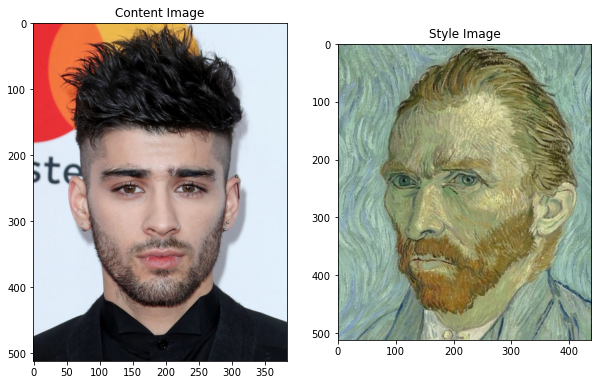

In [7]:
content = load_file(content_path)
style = load_file(style_path)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [8]:
# defining a function to process image for input to vgg19 model

def img_preprocess(img_path):
    """
    returns : Preprocessed `numpy.array` or a `tf.Tensor` with type `float32` of the form (28,28,3)
    The images are converted from RGB to BGR, then each color channel is
    zero-centered with respect to the ImageNet dataset, without scaling.
    
    accepts : image path (string)
    """
    image = load_file(img_path)
    img = vgg19.preprocess_input(image)
    return img

### VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [9]:
# defining a function to deprocess an image

def deprocess_img(processed_img):
    """
    accepts : preprocessed image's nupy array 
    returns : deprocessed image's numpy array of the form (28,28,3) and type casted to uint8
    """
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x,axis=0)
    assert len(x.shape) == 3
    
    x[:,:,0]+=103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68
    x = x[:,:,::-1] # changing channel orientation from BGR to RGB
    
    x = np.clip(x,0,255).astype('uint8') # np.clip() : same function as tf.clip_by_value()
    return x

In [11]:
# getting necessary layers from VGG19 model

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
number_content = 1;
number_style = 5;

### The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

### To define a model using the functional API, specify the inputs and outputs:

### model = Model(inputs, outputs)

In [12]:
# define function to get VGG19 model with pre-trained weights

def get_model():
    """
    Creates our model with access to intermediate layers. 
  
    This function will load the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model. 
  
    Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers.
    """
    vgg = vgg19.VGG19(include_top=False,weights='imagenet') # get model instance (functional object created)
    vgg.trainable = False                                   # weights need not to be trained
    content_output = [vgg.get_layer(layer).output for layer in content_layers] # keras tensors of content output layer
    style_output = [vgg.get_layer(layer).output for layer in style_layers] # keras tensors of style output layer
    model_output = style_output+content_output # list of tensors
    return models.Model(vgg.input,model_output) # instantiate a model and return it

In [13]:
vgg19.VGG19(include_top = False,weights = 'imagenet').summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


### The content loss function ensures that the activations of the higher layers are similar between the content image and the generated image. The style loss function makes sure that the correlation of activations in all the layers are similar between the style image and the generated image.

### Content loss

> Essentially content loss captures the root mean squared error between the activations produced by the generated image and the content image.

In [15]:
def get_content_loss(noise,target):
    """
    computes content loss
    accepts : noise->list of tensors corresponding to each content layer (each tensor is of the form (422,512,64))
                     (it is made from noise image)
            : target->list of tensors corresponding to each content layer (each tensor is of the form (422,512,64))
                     (it is made from content image)
    """
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

### Style loss

> The goal is to compute a style matrix for the generated image and the style image. Then the style loss is defined as the root mean square difference between the two style matrices. Style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image. `The gram matrix is used to find the correlation between the feature maps of a convolution layer.`

In [16]:
def gram_matrix(tensor):
    """
    accepts : a tensor of shape (28,28,3)
    returns : a gram matrix tensor of shape (3,3)
    """
    channels=int(tensor.shape[-1]) # last dimension is the channel dimension
    vector=tf.reshape(tensor,[-1,channels]) # (28,28,3) changes to (724,3)
    n=tf.shape(vector)[0] # n is 784 if image is 28*28*3
    gram_matrix = tf.matmul(vector,vector,transpose_a=True) # matrix multiplication
    # (channels*channels) dimension matrix
    return gram_matrix/tf.cast(n,tf.float32) # divided by 784.0 (if image is 28*28*3) for scaling

In [17]:
def get_style_loss(noise,target):
    """
    accepts : noise-> list of tensors corresponding to each style layer (each tensor is of the form (422,512,64))
                     (it is made from noise image)
            : target-> list of gram matrix tensor of each layer (each tensor is of the form (64*64))
                     (it is made from style image)
    returns : style loss
    """
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [18]:
# function for getting content image and style image features when applied to the 
# NN architecture

def get_features(model,content_path,style_path):
    """
    accepts : model,content path,style path
    returns : a tuple consisting of
            -> content_feature : list of 1 tensor (corresponding to content layer) of the form (422,512,64)
            -> style_feature : list of 5 tensors (each corresponding to 5 style layers) of the form " " " "
    """
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    # layer[0] just means that we are disregarding the sample number dimension and
    # getting a 28*28*512 content_feature for example
    return content_feature,style_feature

### defining a function to compute total loss

In [19]:
def compute_loss(model,loss_weights,image,gram_style_features,content_features):
    """
    accepts -> functional model
            -> loss_weights : tuple of content wwights and style weights
            -> image : noise (image to be generated) in the form of a tensorlow variable
            -> gram_style_features : list of gram matrix tensors for each corresponding layer
            -> content_features : list of content layer outputs (tensors)
    returns : a tuple of total loss, style loss, content loss
    """
    style_weight,content_weight = loss_weights # tuple unpacking
    
    output = model(image)
    content_loss = 0
    style_loss = 0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features): # making tuples element by element
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
    
    weight_per_layer = 1.0/float(number_content)
    for a,b in zip(noise_content_feature,content_features): # making tuples element by element
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
    
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    return total_loss,style_loss,content_loss
    

### tf.GradientTape() API
> TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [20]:
# defining a function to calculate gradient (METHOD : AUTOMATIC DIFFERENTIATION)

def compute_grads(dictionary):
    """
    accepts a dictionary with the following key value pairs
            -> functional model
            -> loss_weights : tuple of content wwights and style weights
            -> image : noise (image to be generated) in the form of a tensorlow variable
            -> gram_style_features : list of gram matrix tensors for each corresponding layer
            -> content_features : list of content layer outputs (tensors)
    returns : a tuple of gradient , all loss (which is itself a tuple of all 3 losses)
    """
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary) # LOSS IS COMPUTED 
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

# tape.gradient() here computes gradient of cost function w.r.t image parameters

In [21]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    """
    accepts : content path, style path, epochs(default to 500), content weight(default to 1e3), style weight(default to 1e-2)
    returns : best image -> a numpy array of the form (28,28,3), type casted to uint8
            : best loss -> tuple of (total loss,style loss,content loss)
            : image -> a list of images(array form) after every 5 iterations
    """
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    # starting image set as content image itself
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32) # creating a tensorflow variable of type float32 from a numpy array
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    # Adam optimizer used : Adam optimization is a stochastic gradient descent method that is based on
    # adaptive estimation of first-order and second-order moments.
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        
        optimizer.apply_gradients([(grad,noise)]) # it applies gradients to variables
                                                  # it accepts a list of grads, variables pairs
        
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        # clip_by_value : Clips tensor values to a specified min and max.(returns a clipped Tensor)
        noise.assign(clipped) # this method can be used for tensorflow variables
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy()) # It converts a tensor object into an numpy.ndarray object.
            
         #for visualization   
         
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 'style loss: {:.4e}, ' 'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss)) 
            #4e means, 4 decimal places in scientific notation
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

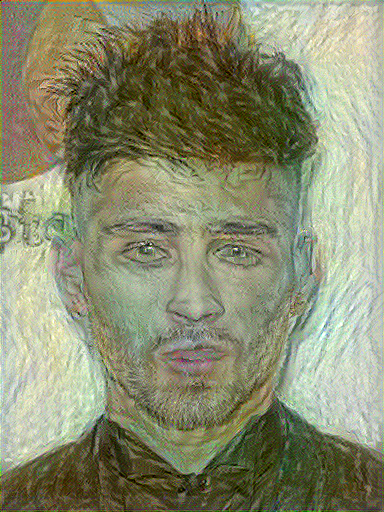

Epoch: 495
Total loss: 4.8947e+05, style loss: 1.2944e+05, content loss: 3.6003e+05, 


In [22]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

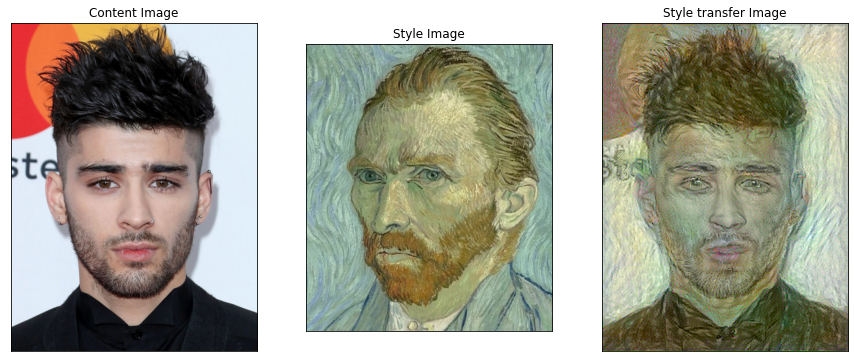

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

<ipython-input-24-bb542565b822>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(4,3,(i/10)+1)


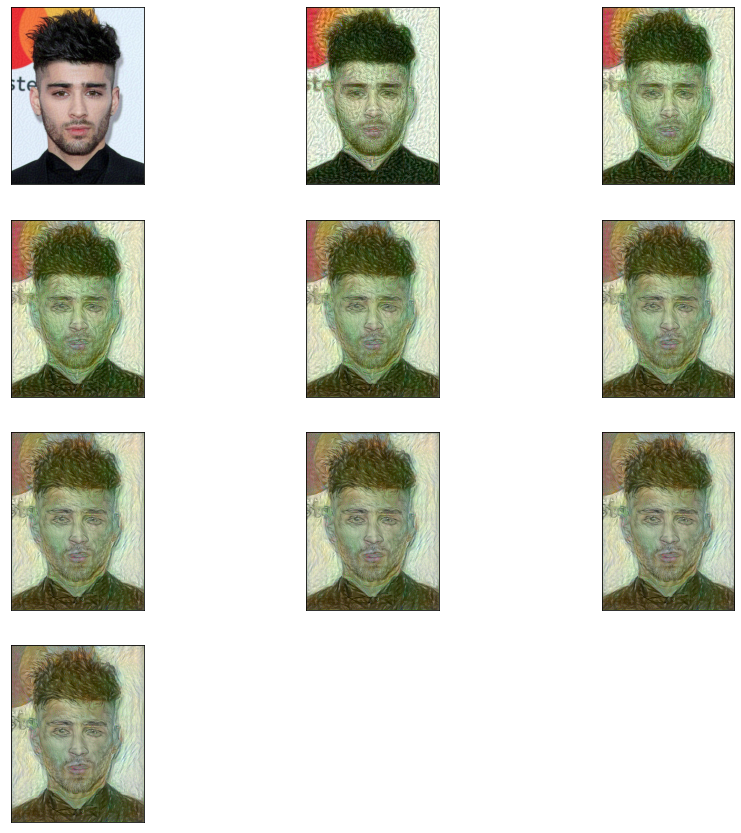

In [24]:
plt.figure(figsize=(15,15))
for i in range(100):
    if(i%10 == 0):
        plt.subplot(4,3,(i/10)+1)
        plt.imshow(image[i])
        plt.xticks([])
        plt.yticks([])